In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from collections import defaultdict, OrderedDict
from einops import rearrange
import matplotlib.pyplot as plt
# from sparseopt.utils.plot import plot_3d
# device = torch.device("cuda:7")
device = torch.device("cpu")

torch.Size([4, 8, 4, 8, 16]) torch.Size([4, 8, 4, 8, 16]) torch.Size([2, 4, 8, 4, 8])


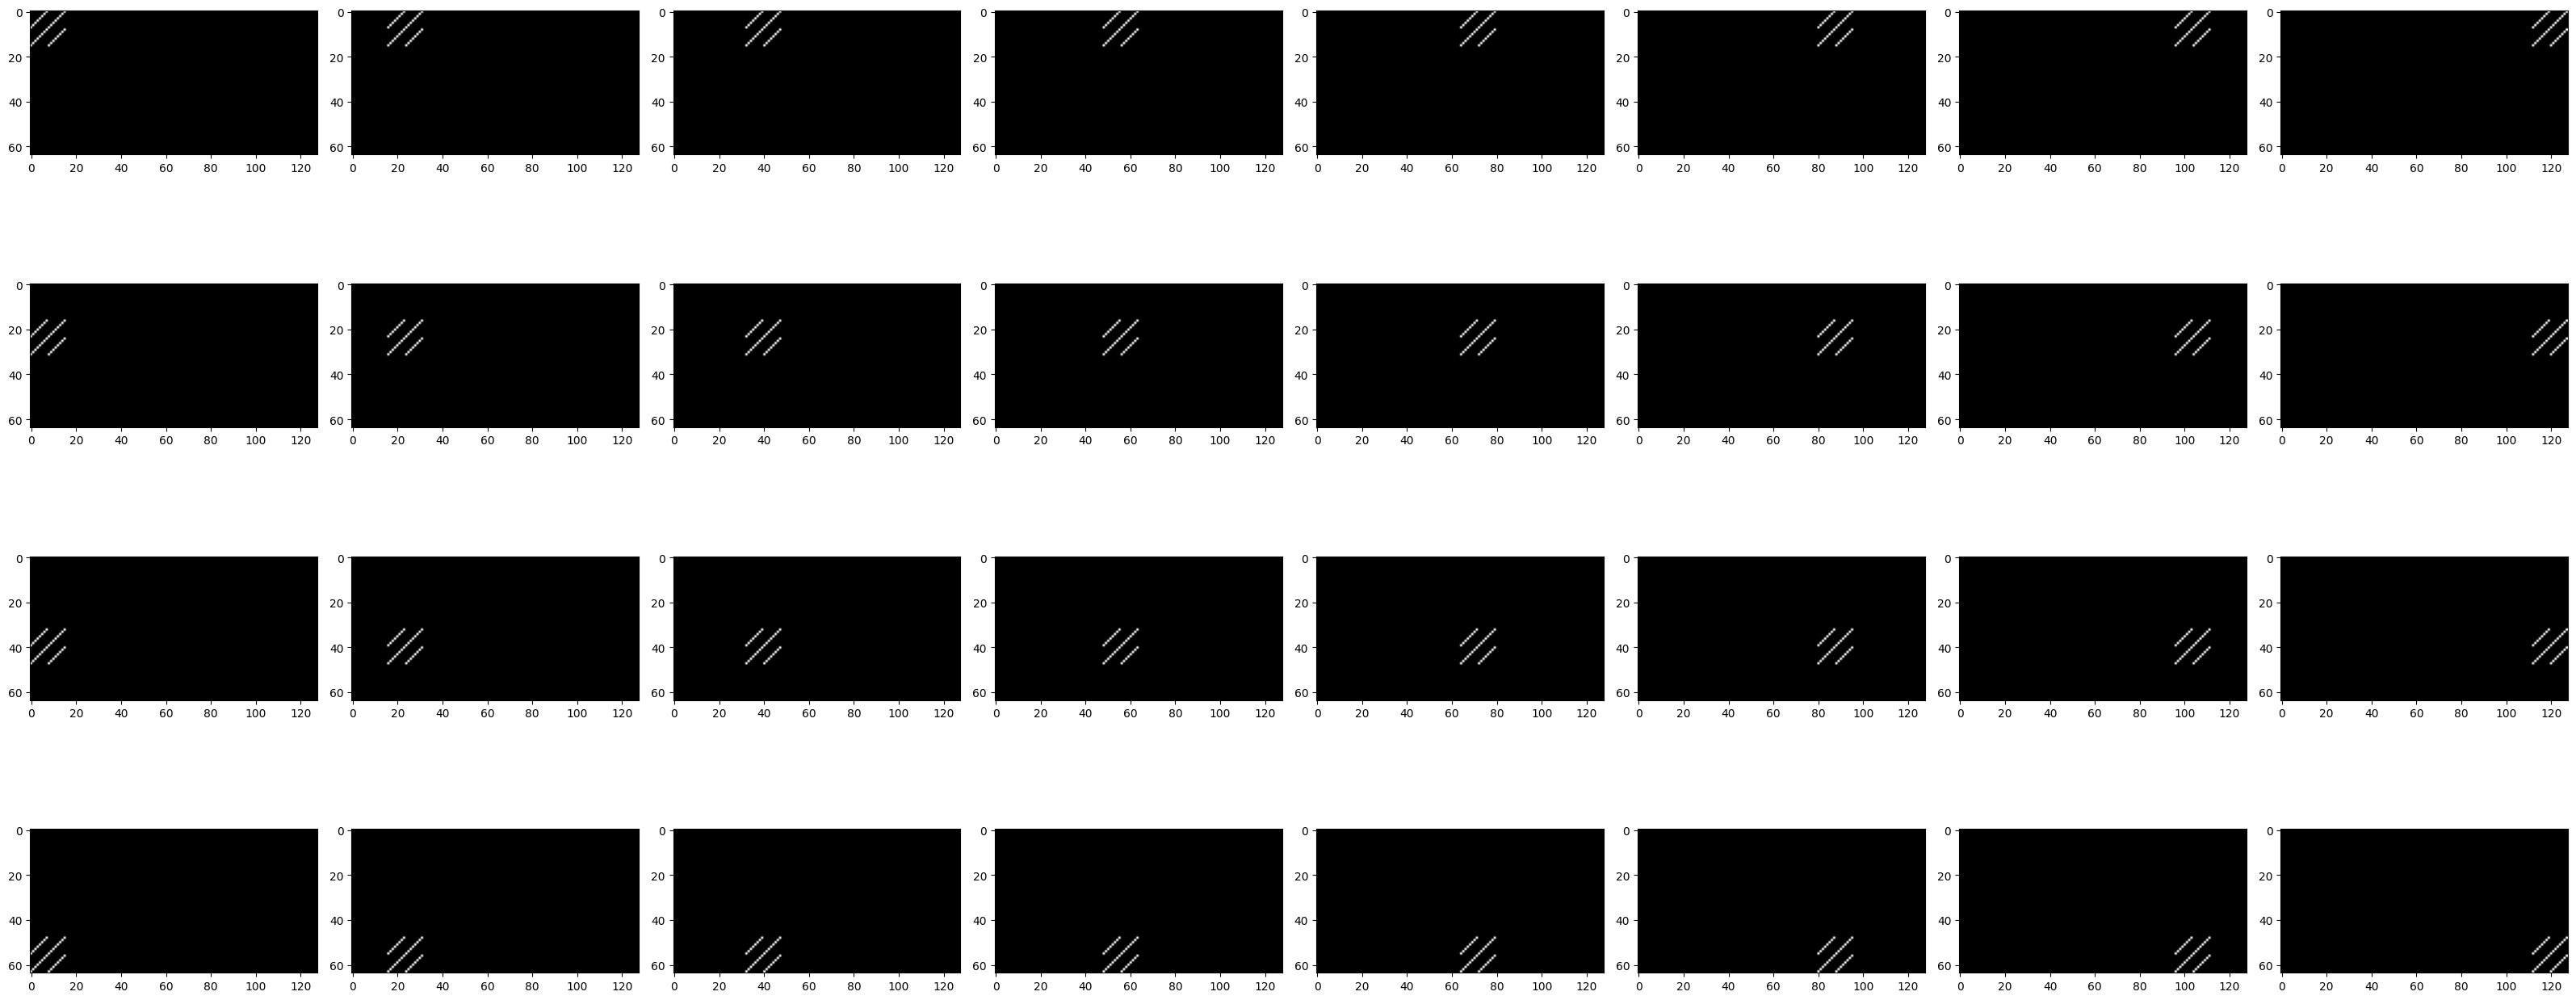

In [3]:
def get_index_old(q_len, k_len, block=16, stride=8, device="cpu"):
    # [Q]
    row = torch.arange(q_len, device=device)
    # [K]
    col = torch.arange(k_len, device=device)
    # [Q, K]
    rows, cols = torch.meshgrid(row, col)
    # [2, Q, K]
    mesh = torch.stack([rows, cols], dim=0)

    # [2, QNS, KNS, QS, KS]
    mesh = rearrange(
        mesh,
        'n (qns qs) (kns ks) -> n qns kns qs ks',
        qs=stride,
        ks=stride
    )
    
    mesh[1] = mesh[1].flip(dims=[-1])
    # [2, QNS, KNS, S, S]
    mask = torch.eye(stride, dtype=torch.bool, device=device).repeat(
        mesh.size(0), mesh.size(1), mesh.size(2), 1, 1
    )
    # [2, QNS, KNS, S]
    mesh = mesh[mask].view(*mesh.shape[:-2], -1)

    # [2, QNB, KNB, B/S*B/S*S]
    mesh = rearrange(
        mesh,
        "n (qnb qbs) (knb kbs) s -> n qnb knb (qbs kbs) s",
        qbs=int(block/stride),
        kbs=int(block/stride),
    )
    return mesh

def get_index(q_len, k_len, block=16, stride=8, device="cpu"):
    assert block % stride == 0
    assert q_len % block == 0 and k_len % block == 0
    row = torch.arange(stride, device=device)
    col = torch.arange(stride, device=device).flip(dims=[0])
    # [2, S]
    mesh = torch.stack([row, col], dim=0)
    # [2, B/S, S]
    mesh = mesh[:, None, ...].repeat(1, block//stride, 1)
    mesh[1] += torch.arange(block//stride, device=device)[:, None] * stride
    # [2, B/S, B/S, S]
    mesh = mesh[:, None, ...].repeat(1, block//stride, 1, 1)
    mesh[0] += torch.arange(block//stride, device=device)[:, None, None] * stride
    # [2, K/B, B/S, B/S, S]
    mesh = mesh[:, None, ...].repeat(1, k_len//block, 1, 1, 1)
    mesh[1] += torch.arange(k_len//block, device=device)[:, None, None, None] * block
    # [2, Q/B, K/B, B/S, B/S, S]
    mesh = mesh[:, None, ...].repeat(1, q_len//block, 1, 1, 1, 1)
    mesh[0] += torch.arange(q_len//block, device=device)[:, None, None, None, None] * block
    mesh = rearrange(mesh, 'n qb kb qs ks s -> n qb kb (qs ks) s')
    return mesh

mesh = get_index(64, 128)
k = torch.randn(128, 16)
q = torch.randn(64, 16)
q_mesh = q[mesh[0]]
k_mesh = k[mesh[1]]
print(q_mesh.shape, k_mesh.shape, mesh.shape)
# print(mesh[0].tolist())
# print(mesh[1].tolist())
# print((mesh[0] + mesh[1]).tolist())

mesh = rearrange(mesh, 'n q k qks s -> q k n (qks s)')
image_size = 4
fig = plt.figure(
    figsize=(image_size*mesh.size(1), image_size*mesh.size(0))
)
fig.subplots_adjust(
    hspace=0.01, wspace=0.01,
    left=0.01, right=0.99,
    top=0.99, bottom=0.1
)
for i in range(mesh.size(0)):
    for j in range(mesh.size(1)):
        ax = fig.add_subplot(
            mesh.size(0), mesh.size(1), 
            i * mesh.size(1) + j + 1,
        )
        row_id = mesh[i, j, 0]
        col_id = mesh[i, j, 1]
        indices = mesh[i, j]
        values = torch.ones(mesh[i, j].size(1))
        data = torch.sparse_coo_tensor(
            indices=indices, 
            values=values,
            size=(64, 128)
        ).to_dense()
        ax.imshow(data.numpy(), cmap='gray')
    plt.tight_layout()


In [50]:
data_dir = "/ssd01/workspace/sglang/exp/data/kv_cache"
# data_file = os.path.join(data_dir, "00.pth")
data_file = os.path.join(data_dir, "60.pth")
data = torch.load(data_file)

/tmp/ipykernel_2045038/1695319549.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_file)


In [51]:
# 评价不同比例的k对结果的影响
current = True
# [QH, Q, D]
q = data["q"].permute(1, 0, 2).to(device)
# [KH, K, D]
k = data["k_cache"]
# 拼上当前的k
if current:
    k = torch.cat([k, data["k"]], dim=0)
k = k.permute(1, 0, 2).to(device)
v = k[:, :, :-64]
scaling = data["scaling"]

# [1, QH, Q, D]
q = q.unsqueeze(0)
# [1, KH, K, D]
k = k.unsqueeze(0)
v = v.unsqueeze(0)
k_len, q_len = k.size(2), q.size(2)

retain_eng_ref = defaultdict(lambda: defaultdict(list))
# percent_list = np.arange(0.1, 1.0)
percent_list = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1]
for i in range(q_len):
# for i in range(30):
    print(f'\rruning: {i} / {q_len}', end='', flush=True)
    k_i = k_len - q_len + i
    # [1, QH, 1, N]
    # [1, QH, 1, K_i]
    full_score = torch.matmul(
        q[:, :, i: i+1],
        k[:, :, :k_i+1].repeat_interleave(q.size(1)//k.size(1), dim=1).transpose(2, 3)
    ) * scaling
    full_score = full_score.softmax(dim=-1)
    full_score = full_score.sort(dim=-1, descending=True).values

    for percent in percent_list:
        retain_eng = full_score[:, :, :, :int(percent*k_i)]
        retain_eng = (retain_eng).sum(dim=-1)
        for j in range(retain_eng.size(1)):
            retain_eng_ref[j][percent].append(retain_eng[:, j].tolist())

runing: 8191 / 8192

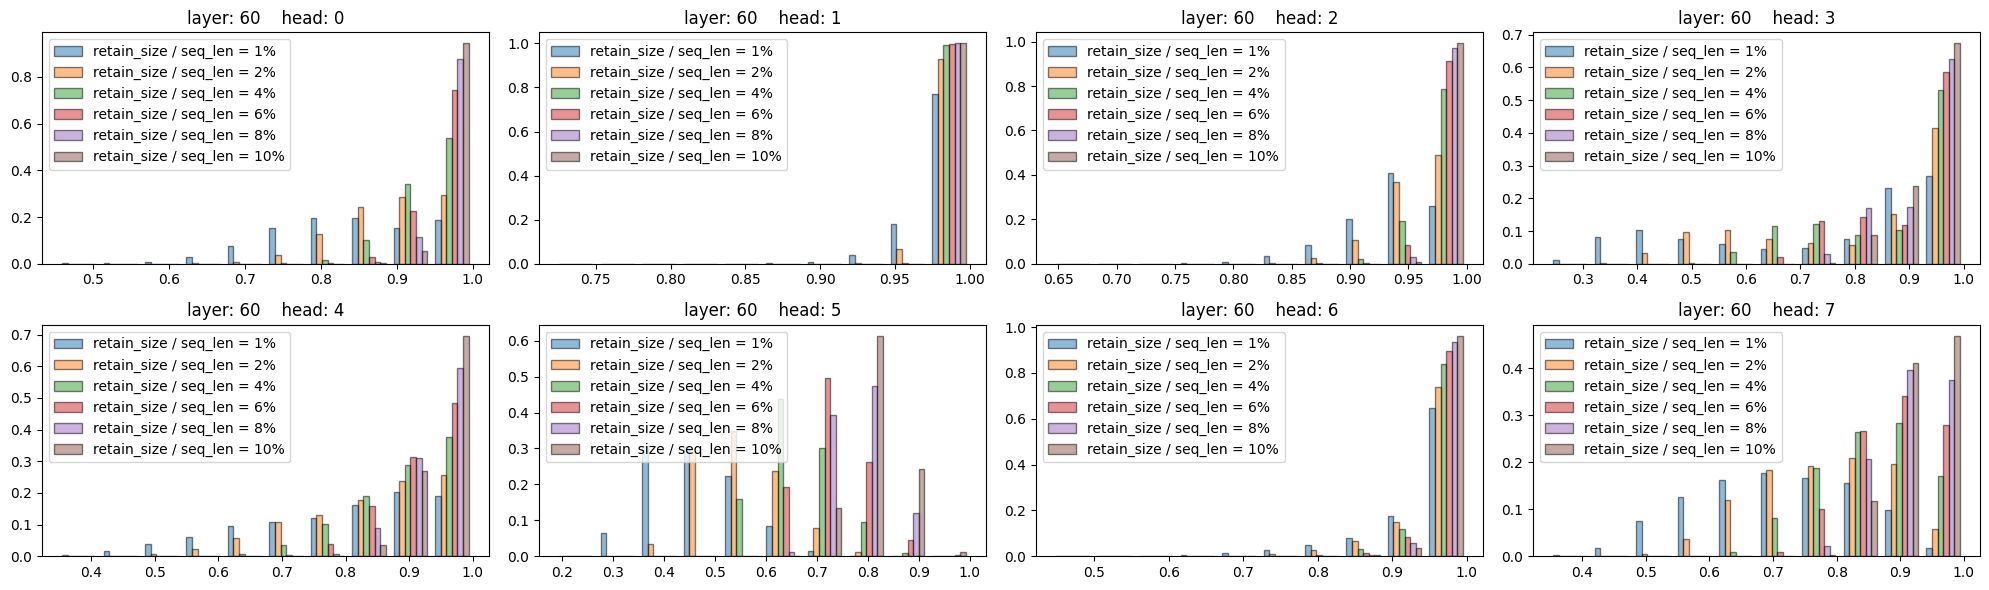

In [52]:
# 画出不同比例token的分布
col = 4
row = int(np.ceil(q.size(1) / col))
fig = plt.figure(figsize=(col * 5, row * 3))
for i, (head_id, infos) in enumerate(retain_eng_ref.items(), 1):
    ax = fig.add_subplot(row, col, i)
    ax.set_title(f"layer: {os.path.splitext(os.path.basename(data_file))[0]}    head: {head_id}")
    plt_data = [
        np.array(info).reshape(-1) for info in infos.values()
    ]
    label = [f"retain_size / seq_len = {key:.0%}" for key in infos.keys()]
    ax.hist(
        plt_data, edgecolor='black', label=label, alpha=0.5,
        weights=[np.ones_like(np.ones_like(np_arr))/len(np_arr) for np_arr in plt_data],
        bins=10
    )
    ax.legend()
plt.tight_layout()

In [11]:
# DoubleSparse 误差结果分析
out_dir = "/ssd01/workspace/sglang/exp/data/analysis"

sparsity = 0.
num_bits = {"high": -1, "low": 0}
retain_size = 2048
# retain_size = 4096
# retain_size = 8192
record_name = f"gt{retain_size}"

# sparsity = 0.875
# num_bits = {"high": 4, "low": 0}
# retain_size = 2048
# # retain_size = 4096
# # retain_size = 8192
# record_name = f"db{retain_size}"

record_file = os.path.join(out_dir, f'{record_name}.pt')
assert not os.path.exists(record_file)

current = True
# [QH, Q, D]
q = data["q"].permute(1, 0, 2).to(device)
# [KH, K, D]
k = data["k_cache"]
# 拼上当前的k
if current:
    k = torch.cat([k, data["k"]], dim=0)
k = k.permute(1, 0, 2).to(device)
v = k[:, :, :-64]
scaling = data["scaling"]

from sparseopt.attns.retriever import TokenSparseRetriever
retriever = TokenSparseRetriever(
    active=True,
    retain_size=retain_size,
    chunk_size=1,
    recent_size=40,
    bank_size=64,
    sparsity=sparsity,
    sparse_mode="per_bank",
    quant_mode="per_bank",
    num_bits=num_bits,
    share=True,
    share_mode="mean",
    mean_trick=False,
    softmax_scale=True,
    topk_version='v0',
    # all_reduce=True,
    prefill_chunk=True,
    qk_scaling=scaling,
)

# [1, QH, Q, D]
q = q.unsqueeze(0)
# [1, KH, K, D]
k = k.unsqueeze(0)
v = v.unsqueeze(0)
k_len, q_len = k.size(2), q.size(2)
if k_len > q_len:
    retriever.update_n(k[:, :, :-q_len])

retain_len_list = []
retain_eng_list = []
diff_list = []
dense_max_list = []
out_diff_list = []
dense_out_list = []
for i in range(q_len):
# for i in range(30):
    print(f'\rruning: {i} / {q_len}', end='', flush=True)
    k_i = k_len - q_len + i
    retriever.update_n(k[:, :, k_i: k_i + 1])
    # [1, QH, 1, N]
    idx = retriever._fetch_idx(q[:, :, i: i + 1], None)
    # print((idx[:, 1] == idx[:, 7]).all())
    # [1, QH, 1, K_i]
    full_score = torch.matmul(
        q[:, :, i: i+1],
        k[:, :, :k_i+1].repeat_interleave(q.size(1)//k.size(1), dim=1).transpose(2, 3)
    ) * scaling
    # [1, QH, 1, K_i]
    mask = torch.zeros_like(full_score)
    mask.scatter_(dim=3, index=idx, value=1)
    retain_len_list.append(mask.float().mean(dim=3).flatten().tolist())
    
    partial_score = torch.where(mask.bool(), full_score, torch.finfo(full_score.dtype).min)
    full_score = full_score.softmax(dim=-1)
    partial_score = partial_score.softmax(dim=-1)
    retain_eng = (full_score * mask).sum(dim=3)
    retain_eng_list.append(retain_eng.tolist())
    # mask error between full score and partial score
    diff = (full_score - partial_score).abs().max(dim=-1).values
    diff_list.append(diff.flatten().tolist())
    dense_max_list.append(full_score.abs().max(dim=-1).values.flatten().tolist())

    full_out = torch.matmul(full_score, v.repeat_interleave(q.size(1)//k.size(1), dim=1)[:, :, :k_i+1])
    partial_out = torch.matmul(partial_score, v.repeat_interleave(q.size(1)//k.size(1), dim=1)[:, :, :k_i+1])
    out_diff_list.append((full_out - partial_out).abs().max(dim=-1).values.flatten().tolist())
    dense_out_list.append(full_out.abs().max(dim=-1).values.flatten().tolist())

record = {
    "retain_len": retain_len_list,
    "retain_eng": retain_eng_list,
    "diff": diff_list,
    "dense_max": dense_max_list,
    "out_diff": out_diff_list,
    "dense_out": dense_out_list
}
os.makedirs(out_dir, exist_ok=True)
torch.save(record, record_file)

runing: 2 / 8192

runing: 8191 / 8192

/tmp/ipykernel_1711285/2020582798.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  name: torch.load(os.path.join(out_dir, f'{name}.pt')) for name in names


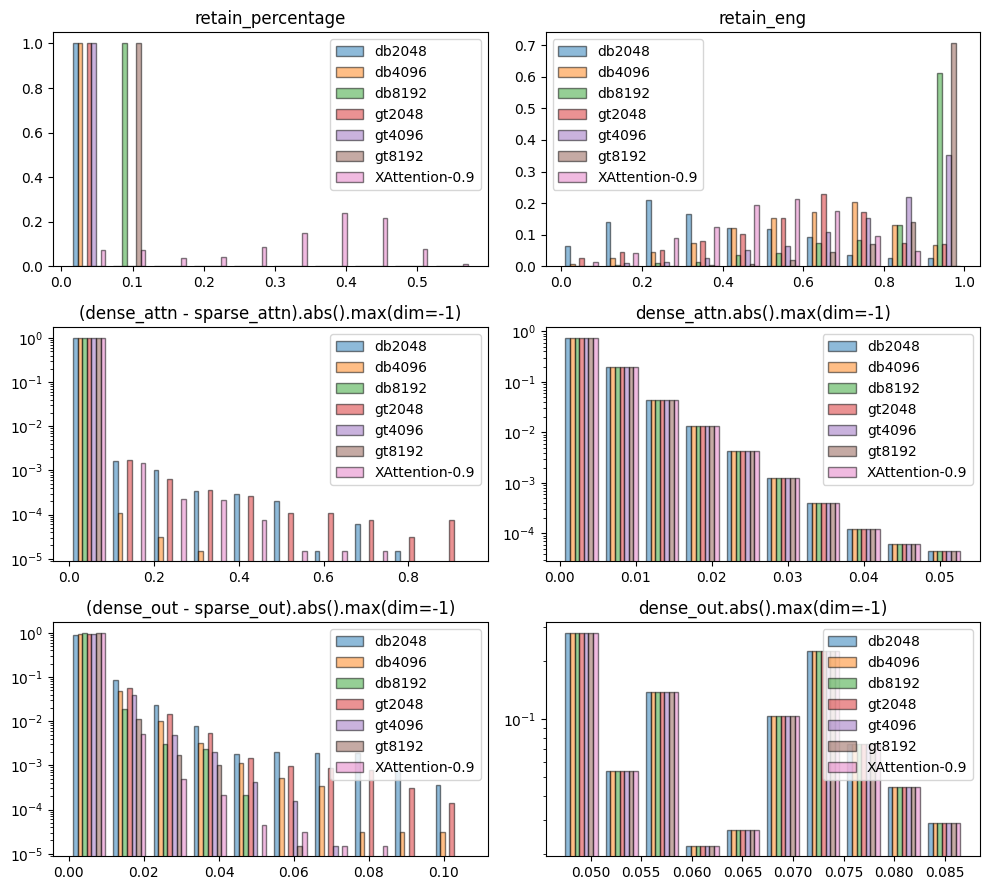

In [12]:
# conbine all: 画出所有的误差图
from collections import OrderedDict
names = [
    'db2048',
    'db4096',
    'db8192',
    'gt2048',
    'gt4096',
    'gt8192',
    'XAttention-0.9'
]
info_names2setting = OrderedDict({
    "retain_len": ("retain_percentage", False),
    "retain_eng": ("retain_eng", False),
    "diff": ("(dense_attn - sparse_attn).abs().max(dim=-1)", True),
    "dense_max": ("dense_attn.abs().max(dim=-1)", True),
    "out_diff": ("(dense_out - sparse_out).abs().max(dim=-1)", True),
    "dense_out": ("dense_out.abs().max(dim=-1)", True),
})
out_dir = '/ssd01/workspace/sglang/exp/data/analysis'
infos = {
    name: torch.load(os.path.join(out_dir, f'{name}.pt')) for name in names
}

row, col = 3, 2
fig = plt.figure(figsize=(col * 5, row * 3))
for i, (info_name, (title, log)) in enumerate(info_names2setting.items(), 1):
    if not info_name:
        continue
    ax = fig.add_subplot(row, col, i)
    ax.set_title(title)
    plt_data = [
        np.array(infos[name][info_name]).reshape(-1) for name in names
    ]
    ax.hist(
        plt_data, edgecolor='black', label=names, alpha=0.5,
        weights=[np.ones_like(np.ones_like(np_arr))/len(np_arr) for np_arr in plt_data],
        log=log,
        bins=10
    )
    ax.legend()
plt.tight_layout()

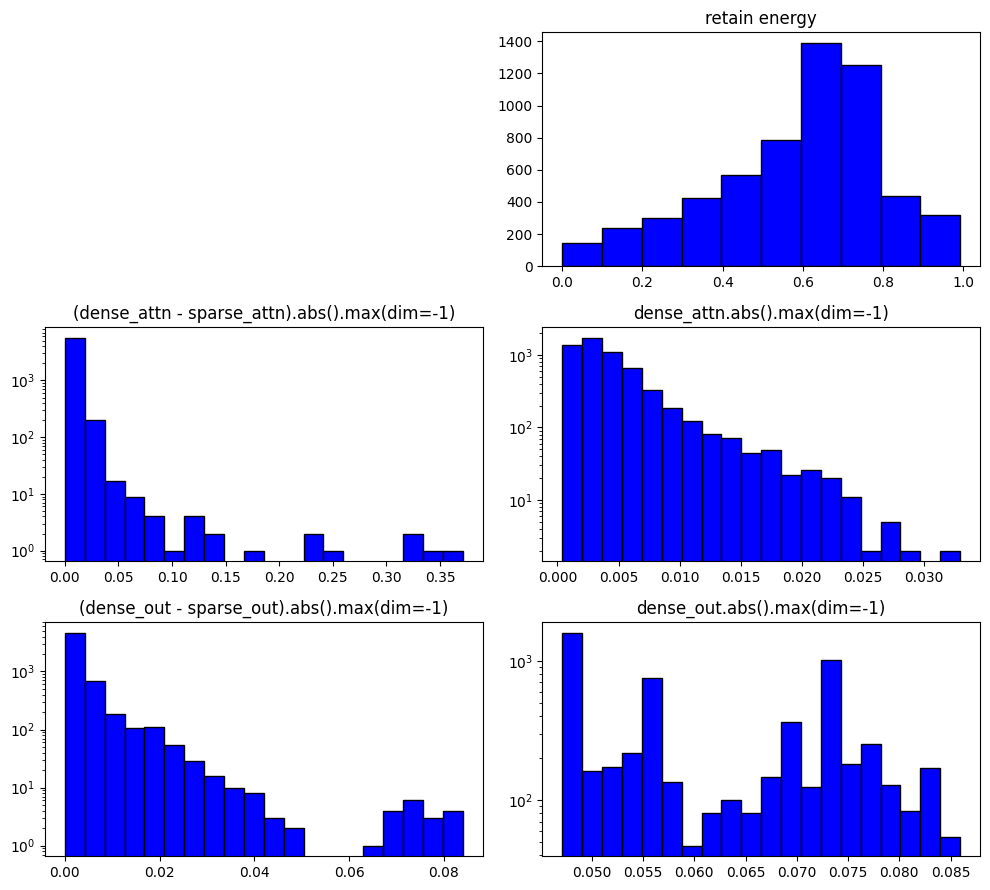

In [ ]:
# 画出当前Double Sparse 误差分布
row, col = 3, 2
fig = plt.figure(figsize=(col * 5, row * 3))
# ax = fig.add_subplot(row, col, 1)
# ax.set_title("retain size / total size")
# retain_len_data = np.array(retain_len_list)
# ax.hist(retain_len_data, color='blue', edgecolor='black')
ax = fig.add_subplot(row, col, 2)
ax.set_title("retain energy")
retain_eng_data = np.array(retain_eng_list).reshape(-1)
ax.hist(retain_eng_data, color='blue', edgecolor='black')
ax = fig.add_subplot(row, col, 3)
# ax.set_title("(dense_attn - sparse_attn).abs().max(dim=-1) > 0.05")
ax.set_title("(dense_attn - sparse_attn).abs().max(dim=-1)")
diff_data = np.array(diff_list).reshape(-1)
# diff_data = diff_data[diff_data > 0.05]
ax.hist(diff_data, color='blue', edgecolor='black', bins=20, log=True)
ax = fig.add_subplot(row, col, 4)
# ax.set_title("dense_attn.max(-1) > 0.05")
ax.set_title("dense_attn.abs().max(dim=-1)")
dense_max_data = np.array(dense_max_list).reshape(-1)
# dense_max_data = dense_max_data[dense_max_data > 0.05]
ax.hist(dense_max_data, color='blue', edgecolor='black', bins=20, log=True)
ax = fig.add_subplot(row, col, 5)
ax.set_title("(dense_out - sparse_out).abs().max(dim=-1)")
out_diff_data = np.array(out_diff_list).reshape(-1)
# out_diff_data = out_diff_data[out_diff_data > 0.05]
ax.hist(out_diff_data, color='blue', edgecolor='black', bins=20, log=True)
ax = fig.add_subplot(row, col, 6)
ax.set_title("dense_out.abs().max(dim=-1)")
dense_out_data = np.array(dense_out_list).reshape(-1)
# out_diff_data = out_diff_data[out_diff_data > 0.05]
ax.hist(dense_out_data, color='blue', edgecolor='black', bins=20, log=True)
plt.tight_layout()

In [5]:
# XAttention 误差分析
out_dir = "/ssd01/workspace/sglang/exp/data/analysis"
record_name = "XAttention-0.9"
record_file = os.path.join(out_dir, f'{record_name}.pt')
assert not os.path.exists(record_file)

current = True
# [QH, Q, D]
q = data["q"].permute(1, 0, 2).to(device)
# [KH, K, D]
k = data["k_cache"]
# 拼上当前的k
if current:
    k = torch.cat([k, data["k"]], dim=0)
k = k.permute(1, 0, 2).to(device)
# [QH, K, D]
k = k.repeat_interleave(q.size(0) // k.size(0), dim=0)
v = k[:, :, :-64]
scaling = data["scaling"]


stride, block = 8, 16
k_len = k.size(1) // block * block
q_len = q.size(1) // block * block
# [2, QB, KB, QKS, S]
mesh = get_index(q_len, k_len, block=block, stride=stride, device=q.device)
fdim  = q.size(2)
retain_len_list = list()
retain_eng_list = list()
diff_list = list()
dense_max_list = list()
out_diff_list = list()
dense_out_list = list()
for i in range(mesh.size(1)):
    scores = list()
    print(f'\rruning: {i} / {mesh.size(1)}', end='', flush=True)
    for j in range(mesh.size(2)):
        # print(f'\rruning: {i} / {mesh.size(1)}, {j} / {mesh.size(2)}', end='', flush=True)
        # [QKS, S]
        q_idx = mesh[0, i, j]
        k_idx = mesh[1, i, j]
        # [QH, Q, D] -> [Q, QH, D] -> [QKS, S, QH, D] -> [QH, QKS, S, D]
        q_mesh = q.transpose(0, 1)[q_idx].permute(2, 0, 1, 3)
        # [QH, K, D] -> [K, QH, D] -> [QKS, S, QH, D] -> [QH, QKS, S, D]
        k_mesh = k.transpose(0, 1)[k_idx].permute(2, 0, 1, 3)
        # # [QH, QKS, S, D]
        # k_mesh = k_mesh.repeat_interleave(q_mesh.size(0) // k_mesh.size(0), dim=0)
        # [QH, QKS, S]
        score = (q_mesh * k_mesh).sum(-1)
        if current:
            # 处理causal mask
            # [QKS, S]
            mask = q_idx + (k_len - q_len) >= k_idx
            # if mask.any():
            #     print(mask)
            score = torch.where(mask[None], score, torch.finfo(score.dtype).min)
            # score[mask] = torch.finfo(score.dtype).min
            score = score.sum(-1) / mask[None].to(score.dtype).sum(-1)
        else:
            # [QH, QKS]
            score = score.mean(-1)
        score = score * scaling
        scores.append(score)
    # [QH, KB, QKS]
    scores = torch.stack(scores, dim=1)
    # [QH, KB]
    scores = torch.softmax(
        rearrange(scores, 'h kb qks -> h (kb qks)'), dim=-1
    ).view(scores.size()).sum(-1)
    # [QH, KB]
    sort_scores, sort_idx = torch.sort(scores, dim=-1, descending=True)
    cum_scores = torch.cumsum(sort_scores, dim=-1)
    # [QH]
    retain_len = (cum_scores < 0.9).int().sum(-1)
    retain_len_list.extend((retain_len/ scores.size(1)).tolist())
    # [KB]
    range_block = torch.arange(sort_idx.size(-1), device=retain_len.device)
    # [QH, KB]
    mask = range_block[None, :] < retain_len[:, None]
    sort_idx = torch.where(mask, sort_idx, sort_idx[:, :1].repeat(1, sort_idx.size(-1)))
    # [QH, KB]
    mask.zero_()
    mask.scatter_(dim=1, index=sort_idx, value=True)
    # print(mask.int().sum(-1) == retain_len)
    # [QH, B, KB * B]
    mask = mask[:, None, :].repeat_interleave(block, dim=1).repeat_interleave(block, dim=2)

    # [B, K]
    full_score = torch.matmul(
        q[:, block * i :block * (i + 1)], k.transpose(1, 2)
    ) * scaling
    if current:
        # 处理causal mask
        # [K]
        k_idx = torch.arange(k.size(1), device=full_score.device)
        # [B]
        q_idx = torch.arange(block, device=full_score.device) + k_len - q_len + i * block
        # [B, K]
        causal_mask = q_idx[:, None] >= k_idx[None, :]
        full_score = torch.where(causal_mask[None], full_score, torch.finfo(full_score.dtype).min)
        # print(causal_mask)
    partial_score = torch.where(
        mask,
        full_score,
        torch.ones_like(full_score)* torch.finfo(full_score.dtype).min
    )
    full_score = full_score.softmax(dim=-1)
    partial_score = partial_score.softmax(dim=-1)
    # mask error between full score and partial score
    diff = (full_score - partial_score).abs().max(dim=-1).values
    diff_list.append(diff.flatten().tolist())
    dense_max_list.append(full_score.abs().max(dim=-1).values.flatten().tolist())

    # [QH, B]
    retain_eng = torch.where(
        mask,
        full_score,
        0
    ).sum(-1)
    retain_eng_list.append(retain_eng.tolist())

    full_out = torch.matmul(full_score, v)
    partial_out = torch.matmul(partial_score, v)
    out_diff_list.append((full_out - partial_out).abs().max(dim=-1).values.flatten().tolist())
    dense_out_list.append(full_out.abs().max(dim=-1).values.flatten().tolist())
    
    # if i >= 400:
    # if i >= 1:
        # break

record = {
    "retain_len": retain_len_list,
    "retain_eng": retain_eng_list,
    "diff": diff_list,
    "dense_max": dense_max_list,
    "out_diff": out_diff_list,
    "dense_out": dense_out_list
}
os.makedirs(out_dir, exist_ok=True)
torch.save(record, record_file)

runing: 511 / 512

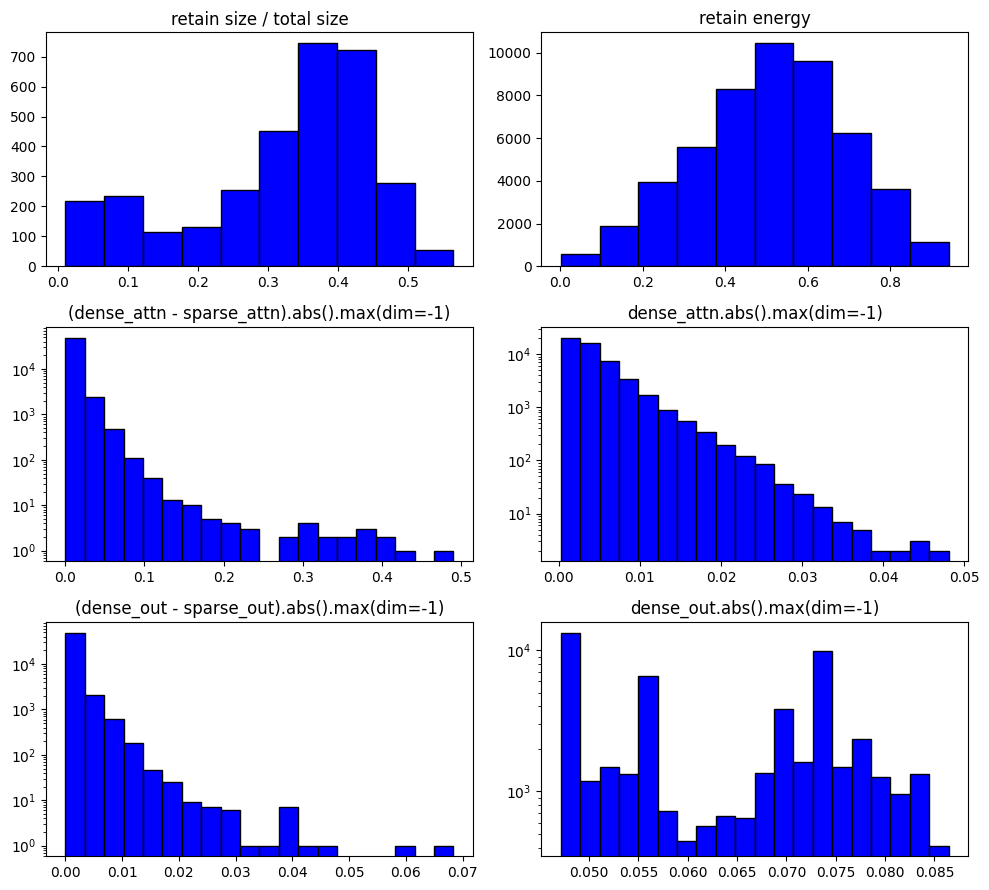

In [ ]:
# 画出当前XAttention误差分布
row, col = 3, 2
fig = plt.figure(figsize=(col * 5, row * 3))
ax = fig.add_subplot(row, col, 1)
ax.set_title("retain size / total size")
retain_len_data = np.array(retain_len_list)
ax.hist(retain_len_data, color='blue', edgecolor='black')
ax = fig.add_subplot(row, col, 2)
ax.set_title("retain energy")
retain_eng_data = np.array(retain_eng_list).reshape(-1)
ax.hist(retain_eng_data, color='blue', edgecolor='black')
ax = fig.add_subplot(row, col, 3)
# ax.set_title("(dense_attn - sparse_attn).abs().max(dim=-1) > 0.05")
ax.set_title("(dense_attn - sparse_attn).abs().max(dim=-1)")
diff_data = np.array(diff_list).reshape(-1)
# diff_data = diff_data[diff_data > 0.05]
ax.hist(diff_data, color='blue', edgecolor='black', bins=20, log=True)
ax = fig.add_subplot(row, col, 4)
# ax.set_title("dense_attn.max(-1) > 0.05")
ax.set_title("dense_attn.abs().max(dim=-1)")
dense_max_data = np.array(dense_max_list).reshape(-1)
# dense_max_data = dense_max_data[dense_max_data > 0.05]
ax.hist(dense_max_data, color='blue', edgecolor='black', bins=20, log=True)
ax = fig.add_subplot(row, col, 5)
ax.set_title("(dense_out - sparse_out).abs().max(dim=-1)")
out_diff_data = np.array(out_diff_list).reshape(-1)
# out_diff_data = out_diff_data[out_diff_data > 0.05]
ax.hist(out_diff_data, color='blue', edgecolor='black', bins=20, log=True)
ax = fig.add_subplot(row, col, 6)
ax.set_title("dense_out.abs().max(dim=-1)")
dense_out_data = np.array(dense_out_list).reshape(-1)
# out_diff_data = out_diff_data[out_diff_data > 0.05]
ax.hist(dense_out_data, color='blue', edgecolor='black', bins=20, log=True)
plt.tight_layout()